# Testing back-propagation model optimization parameters

Test for two insights:
- How initial conditions (ICs) affect the convergence of the model for a fixed n and k.
- How true values affect the performance of ICs.

Testing these cases will allow us to understand efficiency and generalizability.

In this experiment we will open the parameter space to the following values:
- $n \in [2, 8] $ 
- $k \in [-0.1, -10^{-6}] $
- $d \in [300 \, \mu\text{m}, 600 \, \mu\text{m}]$

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models import TransferFunctionModel
from back_prop_utils import H_th_function, round_to_sig_figs
from loss_functions import loss

## Testing a range of ICs for a fixed data point 
We will be exploring two types of IC:
- **Homogeneous**: The n and k are both close or both far from the actual value.
- **Heterogeneous**: Either n or k is close while the other is far.

This should give an understanding of both the impact of ICs on the efficiency of the model as well as how this can be broken down to by parameter.

In [2]:
# Define 4x4 grid of initial conditions
n_IC_values = [2.5, 3.5, 5.5, 7.5]
k_IC_values = [-0.09, -0.05, -0.02, -5e-6]

# Fixed true values
n_true = 3.9
k_true = -0.01
d_true = 499e-6

# Frequency setup
interp = 2**6
freqs_THz = np.linspace(0.1, 5, interp)
freqs = freqs_THz * 1e12
freqs_ang = freqs * 2 * np.pi
w_tensor = torch.tensor(freqs_ang, dtype=torch.float32)

# Generate synthetic experimental data
tf_values = H_th_function((n_true + k_true * 1j), w_tensor, d_true)

H_values_clean = np.abs(tf_values)
phi_values_clean = np.unwrap(np.angle(tf_values))
phi_tensor = torch.tensor(phi_values_clean, dtype=torch.float32)


# Add noise
H_values = H_values_clean + np.random.normal(0, 0.005, size=len(H_values_clean))
phi_values = phi_tensor + np.random.normal(0, 1, size=len(phi_values_clean))

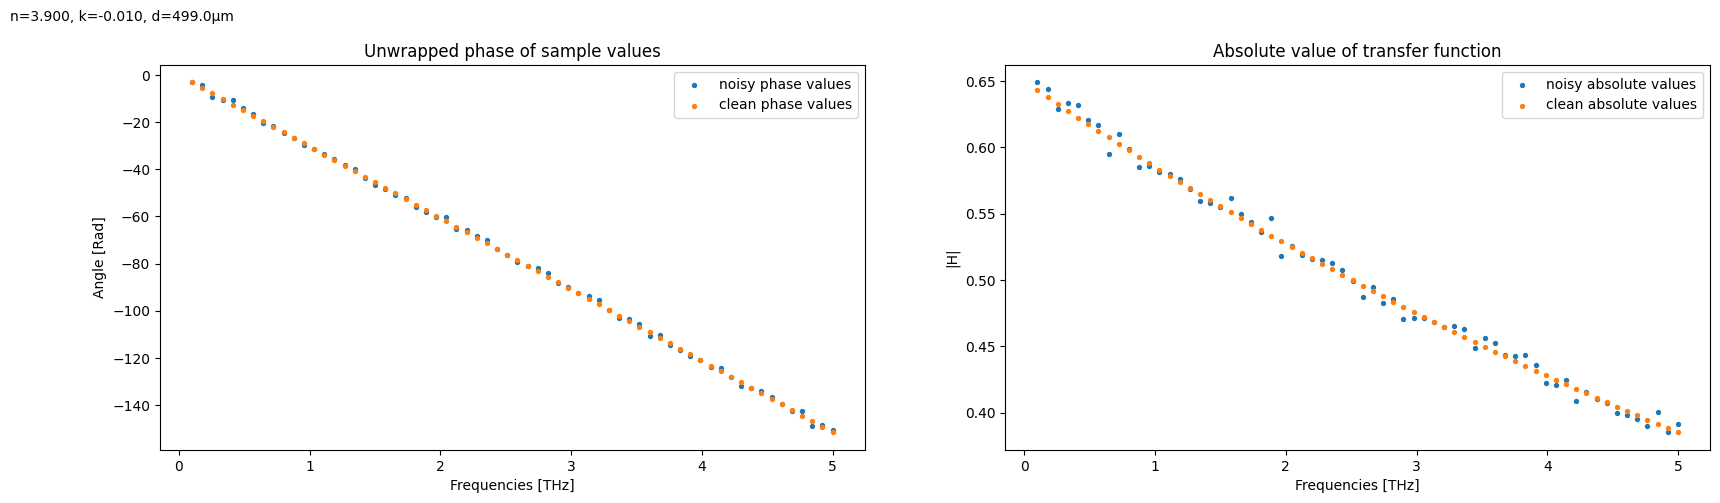

In [3]:
# Plot actual values and noisy signals 
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(freqs_THz, phi_values, s=8, label='noisy phase values')
axs[0].scatter(freqs_THz, phi_values_clean, s=8, label='clean phase values')
axs[0].set_title('Unwrapped phase of sample values')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')

axs[1].scatter(freqs_THz, H_values, s=8, label='noisy absolute values')
axs[1].scatter(freqs_THz, H_values_clean, s=8, label='clean absolute values')
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')

# Annotate with n, k, d values
axs[1].set_ylabel('|H|')

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n={n_true:.3f}, k={k_true:.3f}, d={1e6*d_true:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

axs[0].legend()
axs[1].legend()
plt.show()

In [4]:
# TODO: Check methodology:
# - Determine the optimal epoch (check if it is doing this when reporting stats).
# - Add method to plot optimal epochs.

# Store results
results = []

# Run optimization for each IC pair
for n_IC in n_IC_values:
    for k_IC in k_IC_values:
        # Initialize model
        model = TransferFunctionModel(w_tensor=w_tensor, d=d_true, ICs=[n_IC, k_IC])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # Train the model
        model.train_model(loss, H_values, phi_values, optimizer=optimizer, epochs=10000, verbose=False)

        # Store results
        results.append({
            "IC_n": n_IC,
            "IC_k": k_IC,
            "final_n": model.best_params['n'],
            "final_k": model.best_params['k'],
            "loss_history": model.loss_history[-1]  # Final loss
        })

        print(f"ICs: (n={n_IC}, k={k_IC}) -> Optimized: n = {model.best_params['n']}, k = {model.best_params['k']}")

ICs: (n=2.5, k=-0.09) -> Optimized: n = 3.41300630569458, k = -0.012224286794662476
ICs: (n=2.5, k=-0.05) -> Optimized: n = 3.46028470993042, k = -0.012035674415528774
ICs: (n=2.5, k=-0.02) -> Optimized: n = 3.489565134048462, k = -0.011942030861973763
ICs: (n=2.5, k=-5e-06) -> Optimized: n = 3.431737184524536, k = -0.012145163491368294
ICs: (n=3.5, k=-0.09) -> Optimized: n = 3.8647260665893555, k = -0.010204422287642956
ICs: (n=3.5, k=-0.05) -> Optimized: n = 3.86452579498291, k = -0.010197918862104416
ICs: (n=3.5, k=-0.02) -> Optimized: n = 3.864717721939087, k = -0.010207109153270721
ICs: (n=3.5, k=-5e-06) -> Optimized: n = 3.8645520210266113, k = -0.010208017192780972
ICs: (n=5.5, k=-0.09) -> Optimized: n = 4.480224132537842, k = -0.007431831210851669
ICs: (n=5.5, k=-0.05) -> Optimized: n = 4.503920078277588, k = -0.007337223272770643
ICs: (n=5.5, k=-0.02) -> Optimized: n = 4.514008522033691, k = -0.007287783548235893
ICs: (n=5.5, k=-5e-06) -> Optimized: n = 4.486849308013916, k = 

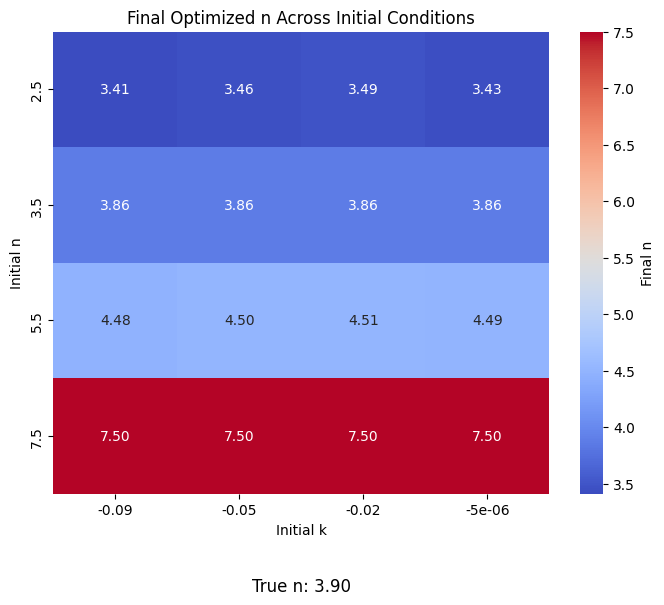

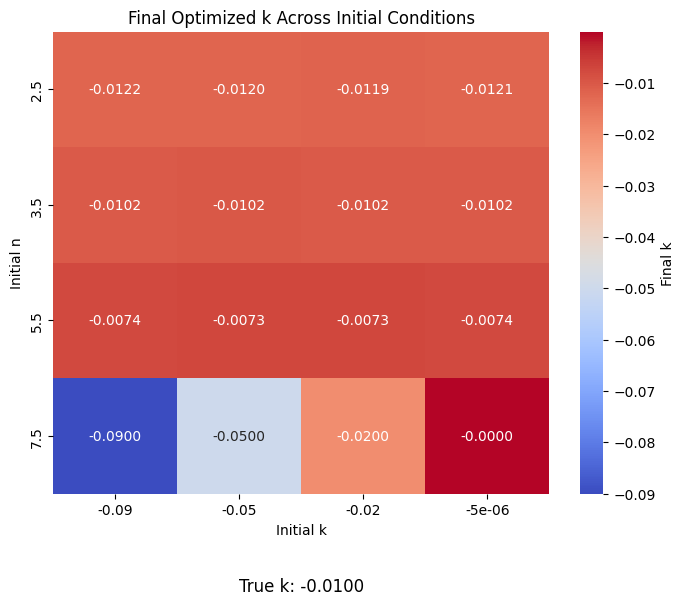

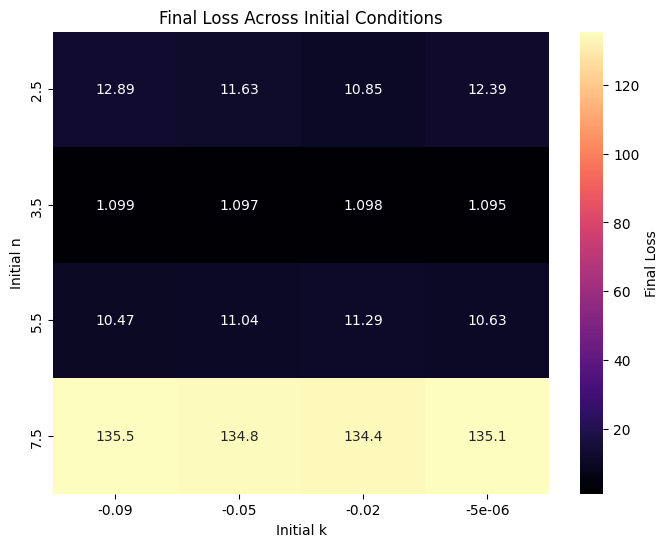

In [5]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# True values
true_n = n_true
true_k = k_true

# Heatmap of final optimized n values
plt.figure(figsize=(8, 6))
pivot_n = df_results.pivot(index="IC_n", columns="IC_k", values="final_n")
ax = sns.heatmap(pivot_n, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Final n'})
plt.title("Final Optimized n Across Initial Conditions")
plt.xlabel("Initial k")
plt.ylabel("Initial n")

# Add annotation for true n value
ax.text(0.5, -0.2, f"True n: {true_n:.2f}", fontsize=12, ha="center", va="center", transform=ax.transAxes)

plt.show()

# Heatmap of final optimized k values
plt.figure(figsize=(8, 6))
pivot_k = df_results.pivot(index="IC_n", columns="IC_k", values="final_k")
ax = sns.heatmap(pivot_k, annot=True, cmap="coolwarm", fmt=".4f", cbar_kws={'label': 'Final k'})  # Increased precision
plt.title("Final Optimized k Across Initial Conditions")
plt.xlabel("Initial k")
plt.ylabel("Initial n")

# Add annotation for true k value
ax.text(0.5, -0.2, f"True k: {true_k:.4f}", fontsize=12, ha="center", va="center", transform=ax.transAxes)

plt.show()

# Heatmap of final loss values
plt.figure(figsize=(8, 6))
pivot_loss = df_results.pivot(index="IC_n", columns="IC_k", values="loss_history")
ax = sns.heatmap(pivot_loss, annot=True, cmap="magma", fmt=".4g", cbar_kws={'label': 'Final Loss'})  # Uses 4 significant figures
plt.title("Final Loss Across Initial Conditions")
plt.xlabel("Initial k")
plt.ylabel("Initial n")
plt.show()

In [6]:
%reset -f

## Testing the Impact of Varying True Parameters (n, k) for a Fixed Initial Condition
We will explore two types of variations:
- **Narrow Range Variations**: We will test values of n and k that are close to their true 
values but still represent a range of plausible initial conditions. This will help us 
understand the model's behavior under realistic parameter variations.
- **Wide Range Variations**: We will test values of n and k that are significantly different 
from their true values, representing extreme initial conditions. This will help us understand 
how robustly the model can be to unusual or outlier-like initial conditions.

This experiment aims to investigate how varying the true parameters (n, k) affects the model's 
performance and behavior for a fixed set of initial conditions, providing insights into the 
model's parameter sensitivity and robustness.